In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [3]:
df = pd.read_parquet('../../data/curated/adjusted_probabilities_2023.parquet')

In [4]:
df

,playerid,match_id,player_first_name,player_last_name,team_name,new_0,new_1,new_2,new_3,exp_votes
0,CD_I1000223,10007,Liam,Baker,Richmond,0.997575,0.001729,0.000598,0.000098,0.003219
1,CD_I1002245,10007,Noah,Balta,Richmond,0.999239,0.000596,0.000146,0.000019,0.000946
2,CD_I993993,10007,Shai,Bolton,Richmond,0.958720,0.023773,0.012841,0.004665,0.063452
3,CD_I295203,10007,Nathan,Broad,Richmond,0.997315,0.001926,0.000637,0.000122,0.003567
4,CD_I270896,10007,Trent,Cotchin,Richmond,0.994717,0.003584,0.001429,0.000270,0.007253
...,...,...,...,...,...,...,...,...,...,...
41,CD_I294305,10199,Lachie,Whitfield,GWS Giants,0.516620,0.149933,0.182604,0.150843,0.967670
42,CD_I1008139,10199,Toby,Bedford,GWS Giants,0.993490,0.004191,0.001943,0.000376,0.009205
43,CD_I290675,10199,Daniel,Lloyd,GWS Giants,0.989708,0.006681,0.002981,0.000630,0.014533
44,CD_I1008123,10199,Jake,Riccardi,GWS Giants,0.996884,0.002262,0.000728,0.000126,0.004097


In [6]:
players = list(df.playerid.unique())
match_ids = list(df.match_id.unique())

In [26]:
num_simulations = 10_000

votes_3 = []
votes_2 = []
votes_1 = []

# simulate 10,000 seasons 
for _ in tqdm(range(num_simulations), desc="Simulations"):
    
    # simulate every game in the season, choose a 3-2-1 vote
    for match in match_ids:
        sub_df = df.query('match_id == @match')
        match_players = sub_df.playerid.tolist()

        match_prob_3 = sub_df.new_3.tolist()
        match_prob_2 = sub_df.new_2.tolist()
        match_prob_1 = sub_df.new_1.tolist()

        vote_3 = np.random.choice(match_players, 1, p=match_prob_3)[0]
        vote_2 = vote_3  # Initialize with a value that requires re-selection
        while vote_2 == vote_3:
            vote_2 = np.random.choice(match_players, 1, p=match_prob_2)[0]

        vote_1 = vote_3  # Initialize with a value that requires re-selection
        while vote_1 == vote_3 or vote_1 == vote_2:
            vote_1 = np.random.choice(match_players, 1, p=match_prob_1)[0]

        votes_3.append(vote_3)
        votes_2.append(vote_2)
        votes_1.append(vote_1)

Simulations: 100%|██████████| 10000/10000 [19:43<00:00,  8.45it/s]


In [27]:
player_votes = {}

In [28]:
for player in tqdm(players):
    
    votes = 3*votes_3.count(player) + 2*votes_2.count(player) + 1*votes_2.count(player)
    
    player_votes[player] = votes / num_simulations

  0%|          | 0/663 [00:00<?, ?it/s]

100%|██████████| 663/663 [02:04<00:00,  5.32it/s]


In [29]:
votes_df = pd.DataFrame(player_votes.items(), columns=['playerid', 'predicted_votes'])

In [30]:
votes_df.sort_values('predicted_votes', ascending=False)[:10]

,playerid,predicted_votes
195,CD_I298210,26.0478
74,CD_I1023261,24.8670
169,CD_I293535,23.7507
365,CD_I992016,22.1223
141,CD_I1006121,21.9738
154,CD_I1001299,21.0723
217,CD_I297373,20.9085
391,CD_I1009420,20.1066
301,CD_I992242,19.8186
262,CD_I1013128,19.0857


In [31]:
player_info = df[['playerid', 'player_first_name', 'player_last_name', 'team_name']].drop_duplicates('playerid')

In [32]:
full_df = pd.merge(player_info, votes_df, on='playerid', how='inner')

In [33]:
full_df.sort_values('predicted_votes', ascending=False, inplace=True)

In [34]:
full_df[:10]

,playerid,player_first_name,player_last_name,team_name,predicted_votes
195,CD_I298210,Christian,Petracca,Melbourne,26.0478
74,CD_I1023261,Nick,Daicos,Collingwood,24.8670
169,CD_I293535,Lachie,Neale,Brisbane Lions,23.7507
365,CD_I992016,Zach,Merrett,Essendon,22.1223
141,CD_I1006121,Zak,Butters,Port Adelaide,21.9738
154,CD_I1001299,Connor,Rozee,Port Adelaide,21.0723
217,CD_I297373,Marcus,Bontempelli,Western Bulldogs,20.9085
391,CD_I1009420,Caleb,Serong,Fremantle,20.1066
301,CD_I992242,Jordan,Dawson,Adelaide Crows,19.8186
262,CD_I1013128,Errol,Gulden,Sydney Swans,19.0857


In [35]:
def present_name(row):
    
    name = f'{row["player_first_name"][0]}. {row["player_last_name"]}'
    
    return name

In [36]:
full_df['player'] = full_df.apply(present_name, axis=1)

In [37]:
final_df = full_df[['player', 'team_name', 'predicted_votes']]

In [38]:
final_df[:10]

,player,team_name,predicted_votes
195,C. Petracca,Melbourne,26.0478
74,N. Daicos,Collingwood,24.8670
169,L. Neale,Brisbane Lions,23.7507
365,Z. Merrett,Essendon,22.1223
141,Z. Butters,Port Adelaide,21.9738
154,C. Rozee,Port Adelaide,21.0723
217,M. Bontempelli,Western Bulldogs,20.9085
391,C. Serong,Fremantle,20.1066
301,J. Dawson,Adelaide Crows,19.8186
262,E. Gulden,Sydney Swans,19.0857


In [39]:
final_df.to_parquet('../../data/curated/final_leaderboard_2023.parquet')

In [40]:
top_5_players = final_df.player[:5]
top_5_votes = final_df.predicted_votes[:5]

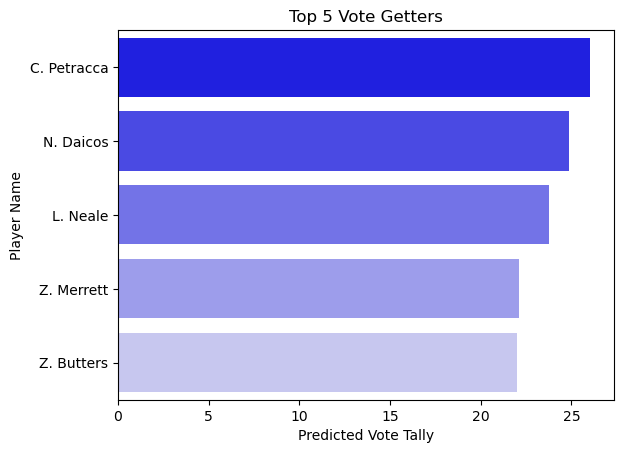

In [46]:
custom_palette = sns.light_palette("blue", reverse=True)


sns.barplot(y=top_5_players, x=top_5_votes, orient='h', palette=custom_palette)

plt.title('Top 5 Vote Getters')
plt.ylabel('Player Name')
plt.xlabel('Predicted Vote Tally')
plt.savefig('../../plots/top_5_predictions_2023.png')
plt.show()